<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/main/GridWorldRLAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
# @title import modules
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import collections
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import os
import time

import logging
log = logging.getLogger(__name__)

# put persistent training data and trained models in google drive
#from google.colab import drive
#drive.mount('/content/drive')
#import jax
#import jax.numpy as jnp
#import flax.linen as nn

In [60]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [61]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [62]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [68]:
# @title Board, Game and Area object definitions for GridWorld

# @markdown define some useful objects

'''
Author: Daniel Cownden
Date: May 26, 2023.
(adapting from othollo board and games classes 
here https://github.com/suragnair/alpha-zero-general/blob/master/othello/OthelloLogic.py)
as well here https://github.com/raymondchua/nma_rl_games
'''

# othello logic is constantly reinstantiating a board and copying stuff around... maybe this
# was necissary for the acceleration??? here we're just going to have one persistent board
# object that we update throughout a game, at least for now until we realize why the reinstantiating/copying was needed.

class gridWorldBoards():
  '''
  Board class.
  Board data:
    1=critter, -1=food, 0=empty
    first dim is row , 2nd is col:
    pieces[1][7] is the square in row 2,
    at the opposite end of the board in column 8.
    Squares are stored and manipulated as (x,y) tuples.
    x is the row, y is the column.
    (note first dim in np.array is row, second dim is col, top left corner is (0,0),
    take care when visualizing/plotting as np.array visualization at odds matplotlib plotting conventions
  '''
  
  def __init__(self, batchSize, xSize, ySize, numFood, lifetime):
    "Set up initial board configuration."
    self.xSize = xSize
    self.ySize = ySize
    self.batchSize = batchSize
    self.numFood = numFood
    self.lifetime = lifetime
    #set rounds left and score
    self.roundsLeft = np.zeros(self.batchSize)
    self.scores = np.zeros(self.batchSize)
    # (Re-)create the empty board array.
    self.pieces = np.zeros((self.batchSize, self.xSize, self.ySize))
    
  def initalBoardState(self):
    #set rounds left and score
    self.roundsLeft = np.ones(self.batchSize) * self.lifetime
    self.scores = np.zeros(self.batchSize)
    # (Re-)create the empty board array.
    self.pieces = np.zeros((self.batchSize, self.xSize, self.ySize))
    # Place critter and initial food items on the board randomly
    for ii in np.arange(self.batchSize):
      intLoc = np.random.choice(self.xSize*self.ySize, self.numFood+1, replace=False)
      xyLoc = np.unravel_index(intLoc, (self.xSize, self.ySize)) # (int(intLoc/self.ySize), intLoc%self.ySize)
      self.pieces[(ii, xyLoc[0][0], xyLoc[1][0])] = 1 # critter random start location
      self.pieces[(ii, xyLoc[0][1:], xyLoc[1][1:])] = -1 # food random start locations
    return(self.pieces.copy(), self.scores.copy(), self.roundsLeft.copy())

  def setState(self, board):
    """ board is a triple of np arrays 
    (pieces,       - batchSize x xSize x ySize 
     scores,       - batchSize x 1
     roundsLeft)   - batchSize x 1
    """
    self.pieces, self.scores, self.roundsLeft = board

  def getState(self):
    return(self.pieces.copy(), self.scores.copy(), self.roundsLeft.copy())
    
  def __getitem__(self, index): 
    return self.pieces[index]
  
  def executeMoves(self, moves):
    """
    moves is 3-tuple of 1-d arrays each of length batchSize, the first array gives the game,
    the second array in the tuple gives the new x coordinates, 
    and the third gives the new y coordinates 
    this assumes the move is valid, i.e.
    doesn't check for bounce/reflection, only checks eating and adds new food
    """
    #critters leave their spots
    self.pieces[self.pieces==1] = 0

    #which critters have food in their new spots
    eatsFood = self.pieces[moves] == -1
    # some critters eat and scores go up
    #print(self.scores)
    self.scores = self.scores + eatsFood
    #print(self.scores)

    numEmptyAfterEat = self.xSize*self.ySize - self.numFood #-1 for the critter +1 for food eaten
    gEating = np.where(eatsFood)[0]

    newFoodSample = np.random.choice(numEmptyAfterEat, size=np.sum(eatsFood))

    # add random food to replace what is eaten
    if np.any(eatsFood):
      possibleNewFoodLocs = np.where(np.logical_and(self.pieces == 0, #the spot is empty
                                                    eatsFood.reshape(self.batchSize, 1, 1))) #food was eaten on that board
      newFoodSample = np.random.choice(numEmptyAfterEat, size=np.sum(eatsFood))
      newFoodSample_ = newFoodSample + np.arange(len(gEating))*numEmptyAfterEat
      assert np.all(self.pieces[(possibleNewFoodLocs[0][newFoodSample_], 
                                 possibleNewFoodLocs[1][newFoodSample_], 
                                 possibleNewFoodLocs[2][newFoodSample_])] == 0)
      
      #put new food on the board
      self.pieces[(possibleNewFoodLocs[0][newFoodSample_], 
                   possibleNewFoodLocs[1][newFoodSample_], 
                   possibleNewFoodLocs[2][newFoodSample_])] = -1
      
    # put critters in new positions
    self.pieces[moves] = 1.0
    self.roundsLeft = self.roundsLeft - 1
    assert np.all(self.pieces.sum(axis=(1,2)) == ((self.numFood * -1) + 1))

  def getLegalMoves(self):
    """Returns all the legal moves for the critter, taking into acount
    bouncing/reflection at edges, recall moves are g,x,y triples, actions are 
    integers returns batch x numPossibleOffsets(4) x coord (3)
    """
    
    #apply all possible offsets to each game
    moves = np.stack([
      np.array(np.where(self.pieces == 1)) + np.array([np.array([0,  1, 0])]*self.batchSize).T,
      np.array(np.where(self.pieces == 1)) + np.array([np.array([0, -1, 0])]*self.batchSize).T,
      np.array(np.where(self.pieces == 1)) + np.array([np.array([0, 0,  1])]*self.batchSize).T,
      np.array(np.where(self.pieces == 1)) + np.array([np.array([0, 0, -1])]*self.batchSize).T]).swapaxes(0,2)
    
    #check bounces at boundaries
    moves[:,1,:] = np.where(moves[:,1,:] >= self.xSize, self.xSize-2, moves[:,1,:])
    moves[:,2,:] = np.where(moves[:,2,:] >= self.ySize, self.ySize-2, moves[:,2,:]) 
    moves[:,1,:] = np.where(moves[:,1,:] < 0, 1, moves[:,1,:])
    moves[:,2,:] = np.where(moves[:,2,:] < 0, 1, moves[:,2,:])
    return moves

class gridWorldGames():
  """
  Instantiate a Gridworld Game
  """
  square_content = {
      -1: "X", #Food
      +0: "-", #Nothing
      +1: "O"  #Critter
      }

  def getSquarePiece(self, piece):
    return gridWorldGames.square_content[piece]

  def __init__(self, batchSize, xSize, ySize, numFood, lifetime):
    self.batchSize = batchSize
    self.xSize = xSize
    self.ySize = ySize
    self.numFood = numFood
    self.lifetime = lifetime

  def getInitBoard(self):
    # returns a tuple giving current state of the game, in terms of board position,
    # current score, and rounds left in the episode
    b = gridWorldBoards(self.batchSize, self.xSize, self.ySize, self.numFood, self.lifetime)
    b.initalBoardState()
    return (b.pieces, b.scores, b.roundsLeft)

  def getBoardSize(self):
    # (a,b) tuple
    return (self.xSize, self.ySize)

  def getActionSize(self):
    # Return number of actions, only 2-4 of these will ever be valid,
    # actions correspond to integer indexes of board locations, moves to x,y representations of 
    return self.xSize * self.ySize

  def getBatchSize(self):
    # Return number of actions, only 2-4 of these will ever be valid,
    # actions correspond to integer indexes of board locations, moves to x,y representations of 
    return self.batchSize

  def stringRepresentation(self, board, g):
    ''' return a string representation for the state specific game g in the set of boards)'''
    return board[0][g].tobytes() + board[1][g].tobytes() + board[2][g].tobytes()

  def stringRepresentationReadable(self, board, g):
    board_s = "".join([self.square_content[square] for row in board[0][g] for square in row])
    board_s = board_s + '_' + str(board[1][g])
    board_s = board_s + '_' + str(board[2][g])
    return board_s
  
  def getScores(self, board):
    return board[1].copy()

  def getRoundsLeft(self, board):
    return board[2].copy()

  def display(self, board, g):
    """Dispalys the g-th games in the batch of boards"""
    print("   ", end="")
    for y in range(self.ySize):
      print(y, end=" ")
    print("")
    print("-----------------------")
    for y in range(self.ySize):
      print(y, "|", end="")    # Print the row
      for x in range(self.xSize):
        piece = board[0][g][y][x]    # Get the piece to print
        print(gridWorldGames.square_content[piece], end=" ")
      print("|")
    print("-----------------------")
    print("Rounds Left: " + str(board[2][g]))
    print("Score: " + str(board[1][g]))

  def getValidActions(self, board):
    """
    Helper function to identify valid Actions, which is an array of integer indexes
    Moves are represented as gxy pairs
    Returns:
      valids: np.ndarray
        Returns a fixed size binary vector
    """
    batchSize, xSize, ySize = board[0].shape
    b = gridWorldBoards(batchSize, xSize, ySize, self.numFood, self.lifetime)
    b.setState(board)
    legalMoves =  b.getLegalMoves()
    valids = np.zeros((batchSize, xSize * ySize))
    for ii, g in enumerate(legalMoves[:,1:,:]):
      for x,y in zip(g[0],g[1]):
        valids[ii, x*self.ySize+y] = 1
    return valids

  def displayMoves(self, board, g):
    # Display possible moves for the g-th games in the batch
    batchSize, xSize, ySize = board[0][0].shape
    A=np.reshape(self.getValidActions(board)[g], (xSize, ySize))
    print("  ")
    print("possible moves")
    print("   ", end="")
    for y in range(self.ySize):
      print(y, end=" ")
    print("")
    print("-----------------------")
    for y in range(self.ySize):
      print(y, "|", end="")    # Print the row
      for x in range(self.xSize):
        piece = A[y][x]    # Get the piece to print
        print(gridWorldGames.square_content[piece], end=" ")
      print("|")
    print("-----------------------")

  def getNextState(self, board, actions):
    """
    Helper function to make valid move
    If player takes action on board, return next board
    and action must be a valid move

    Args:
      boards:
      action: flat integer index of board position indicating where creature moves

    Returns:
      board signifying next state
    """
    #print(actions)
    batchSize, xSize, ySize = board[0].shape
    if len(actions) != batchSize:
      print(board[0])
      print(actions)
    if board[2][0] <= 0:
      # assumes all boards have the same rounds left
      # no rounds left return the board unchanged
      return board
    else:
      moves = (np.arange(len(actions)), 
               np.floor_divide(actions, ySize), 
               np.remainder(actions, ySize))
      b = gridWorldBoards(len(actions), xSize, ySize, self.numFood, self.lifetime)
      b.setState(board)
      b.executeMoves(moves)
      return b.getState()

  def getNextState_multiActions(self, board, actions, actionIndx):
    """
    Helper function to make multiple valid moves in parellel,
    i.e. a branching of the game tree

    Args:
      board: is original boards
      action: flat integer index of board position indicating where creatures move
      actionIndx: shows which actions correspond to which original boards 
      (this was 1-1 and implicit in the order of getNextState)

    Returns:
      board signifying next state
    """
    #print(actions)
    batchSize, xSize, ySize = board[0].shape
    if board[2][0] <= 0:
      # assumes all boards have the same rounds left
      # no rounds left return the board unchanged
      return board
    else:
      moves = (np.arange(len(actions)), 
               np.floor_divide(actions, ySize), 
               np.remainder(actions, ySize))
      b = gridWorldBoards(len(actions), xSize, ySize, self.numFood, self.lifetime)
      newPieces = np.array([board[0][ai].copy() for ai in actionIndx])
      newScores = np.array([board[1][ai].copy() for ai in actionIndx])
      newRoundsLeft = np.array([board[2][ai].copy() for ai in actionIndx])
      b.setState((newPieces, newScores, newRoundsLeft))
      b.executeMoves(moves)
      return b.getState()

  def getGameEnded(self, board):
    """
    Helper function to signify if game has ended

    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]
      player: Integer
        ID of current player

    Returns:
      0 if not ended, and score if it is ended
    """
    roundsLeft = board[2]
    scores = board[1]
    if np.any(roundsLeft >= 1):
      return np.ones(self.batchSize) * -1.0
    else:
      return scores

  def getSymmetries(self, board, pi):
    """
    Get mirror/rotational configurations of board

    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]
      pi: np.ndarray
        Dimension of board

    Returns:
      l: list
        90 degree of board, 90 degree of pi_board
    """
    assert(len(pi) == self.xSize*self.ySize)
    pi_board = np.reshape(pi, (self.xSize, self.ySize))
    l = []

    for i in range(1, 5):
      for j in [True, False]:
        newB = np.rot90(board[0], i)
        newPi = np.rot90(pi_board, i)
        if j:
          newB = np.fliplr(newB)
          newPi = np.fliplr(newPi)
        l += [(newB, list(newPi.ravel()) + [pi[-1]])]
    return l


def playGame(game, player, verbose=False):
  """
  Executes one episode (complete play through) of a (batch of) game(s).
  Args:
    game object like defined above
    instance of a player class with a play method that takes board states and returns actions
  Returns:
    players scores from the game(s)
  """
  it = 0
  boardState = game.getInitBoard()
  if verbose:
    assert game.display
    print("Turn 0: Initial State")
    # only ever show one game from the batch
    game.display(boardState, 0)
  while np.any(game.getGameEnded(boardState) == -1):
    it += 1
    actions, probs_ = player.play(boardState)
    boardState = game.getNextState(boardState, actions)
    #print(boardState)
    if verbose:
      assert game.display
      print("Turn ", str(it))
      game.display(boardState, 0)
      print("=====================")
      
  if verbose:
    print("Game over: Turn ", str(it), "Results: ", str(game.getGameEnded(boardState)))
  return game.getGameEnded(boardState)

In [6]:
gwg = gridWorldGames(4, 7, 7, 20, 30)

In [7]:
initBoard = gwg.getInitBoard()
print(initBoard[0].shape)

(4, 7, 7)


In [8]:
gwg.display(initBoard, 0)

   0 1 2 3 4 5 6 
-----------------------
0 |- - - - X - - |
1 |- X X X X - X |
2 |X O - - - X - |
3 |- - X - X - - |
4 |- - - X X - X |
5 |X - - X X X X |
6 |- X - - - X - |
-----------------------
Rounds Left: 30.0
Score: 0.0


In [9]:
print('bytes representation of board state:')
print(gwg.stringRepresentation(initBoard, 0))
print('string representation of board state:')
print(gwg.stringRepresentationReadable(initBoard, 0))
# print(game.getScore())
# Observe the game board size
print(f'Board size = {gwg.getBoardSize()}')
#Observe the batch size
print(f'Batch size = {gwg.getBatchSize()}')
# Observe the action size
print(f'Action size = {gwg.getActionSize()}')

bytes representation of board state:
b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xbf\x00\x00\x00\x00\x00\x00\xf0\xbf\x00\x00\x00\x00\x00\x00\xf0\xbf\x00\x00\x00\x00\x00\x00\xf0\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xbf\x00\x00\x00\x00\x00\x00\xf0\xbf\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [10]:
initBoard[0]

array([[[ 0.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 0., -1., -1., -1., -1.,  0., -1.],
        [-1.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0., -1.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0., -1., -1.,  0., -1.],
        [-1.,  0.,  0., -1., -1., -1., -1.],
        [ 0., -1.,  0.,  0.,  0., -1.,  0.]],

       [[ 0.,  0., -1.,  0., -1., -1., -1.],
        [ 0., -1.,  0., -1.,  0., -1., -1.],
        [ 0., -1., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -1., -1.,  0., -1.,  0.],
        [ 0., -1., -1.,  0.,  0., -1.,  0.],
        [-1.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  0., -1.]],

       [[ 0., -1., -1.,  0., -1.,  0.,  0.],
        [-1., -1., -1.,  1.,  0.,  0., -1.],
        [-1.,  0.,  0.,  0., -1.,  0., -1.],
        [-1., -1.,  0.,  0.,  0.,  0., -1.],
        [-1.,  0., -1.,  0., -1.,  0., -1.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0., -1.]],

       [[-1., -1.,  0.,  0.,  0.,  0., -1.],
    

In [11]:
initBoard[1]

array([0., 0., 0., 0.])

In [12]:
initBoard[2]

array([30., 30., 30., 30.])

In [13]:
(actionIndx, actions) = np.where(gwg.getValidActions(initBoard))
print(actions)
print(actionIndx)

[ 8 14 16 22 15 21 23 29  3  9 11 17 37 43 45]
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3]


In [14]:
for g_ in np.where(actionIndx == 0)[0]:
  print(g_)
  gwg.display(gwg.getNextState_multiActions(initBoard, actions, actionIndx), g_)

0
   0 1 2 3 4 5 6 
-----------------------
0 |- - - - X - - |
1 |- O X X X - X |
2 |X - - - - X - |
3 |X - X - X - - |
4 |- - - X X - X |
5 |X - - X X X X |
6 |- X - - - X - |
-----------------------
Rounds Left: 29.0
Score: 1.0
1
   0 1 2 3 4 5 6 
-----------------------
0 |- - - X X - - |
1 |- X X X X - X |
2 |O - - - - X - |
3 |- - X - X - - |
4 |- - - X X - X |
5 |X - - X X X X |
6 |- X - - - X - |
-----------------------
Rounds Left: 29.0
Score: 1.0
2
   0 1 2 3 4 5 6 
-----------------------
0 |- - - - X - - |
1 |- X X X X - X |
2 |X - O - - X - |
3 |- - X - X - - |
4 |- - - X X - X |
5 |X - - X X X X |
6 |- X - - - X - |
-----------------------
Rounds Left: 29.0
Score: 0.0
3
   0 1 2 3 4 5 6 
-----------------------
0 |- - - - X - - |
1 |- X X X X - X |
2 |X - - - - X - |
3 |- O X - X - - |
4 |- - - X X - X |
5 |X - - X X X X |
6 |- X - - - X - |
-----------------------
Rounds Left: 29.0
Score: 0.0


In [15]:
# @title Define the Random Organism
class randomPlayer():
  """
  Instantiate random player for GridWorld
  """
  def __init__(self, game):
    self.game = game

  def play(self, board):
    """
    Simulates random game play
    Args:
      a board state (pieces, scores, roundsLeft)
    Returns:
      a: [int] a batchSize array randomly chosen actions
    """
    valids = self.game.getValidActions(board)
    batchSize = self.game.getBatchSize()
    actionSize = self.game.getActionSize()
    # Compute the probability of each move being played (random player means this should
    # be uniform for valid moves, 0 for others)
    probs = valids / np.sum(valids, axis=1).reshape(batchSize,1)
    # Pick a random action based on the probabilities
    a = [np.random.choice(actionSize, p=probs[ii]) for ii in range(batchSize)]
    return np.array(a), probs

In [16]:
# @title Watch the random player play
playGame(gwg, randomPlayer(gwg), verbose=True)

Turn 0: Initial State
   0 1 2 3 4 5 6 
-----------------------
0 |X - - - - X - |
1 |X X - X - X - |
2 |- X - - X - - |
3 |- X X - X X O |
4 |- - X - - - X |
5 |X - - X - - - |
6 |X - X - X - X |
-----------------------
Rounds Left: 30.0
Score: 0.0
Turn  1
   0 1 2 3 4 5 6 
-----------------------
0 |X - - - - X - |
1 |X X - X - X - |
2 |X X - - X - - |
3 |- X X - X O - |
4 |- - X - - - X |
5 |X - - X - - - |
6 |X - X - X - X |
-----------------------
Rounds Left: 29.0
Score: 1.0
Turn  2
   0 1 2 3 4 5 6 
-----------------------
0 |X - - - - X - |
1 |X X - X - X - |
2 |X X - - X O - |
3 |- X X - X - - |
4 |- - X - - - X |
5 |X - - X - - - |
6 |X - X - X - X |
-----------------------
Rounds Left: 28.0
Score: 1.0
Turn  3
   0 1 2 3 4 5 6 
-----------------------
0 |X - - - - X - |
1 |X X - X - X - |
2 |X X - - X - - |
3 |- X X - X O - |
4 |- - X - - - X |
5 |X - - X - - - |
6 |X - X - X - X |
-----------------------
Rounds Left: 27.0
Score: 1.0
Turn  4
   0 1 2 3 4 5 6 
----------------

array([10.,  9.,  6.,  8.])

# Training the Value Network

In [17]:
# @title Arguments for training NN
class dotdict(dict):
  def __getattr__(self, name):
    return self[name]

args = dotdict({
  'numIters': 1,            # In training, number of iterations = 1000 and num of episodes = 100
  'numEps': 1,              # Number of complete self-play games to simulate during a new iteration.
  'tempThreshold': 15,      # To control exploration and exploitation
  'updateThreshold': 0.6,   # During arena playoff, new neural net will be accepted if threshold or more of games are won.
  'maxlenOfQueue': 200,     # Number of game examples to train the neural networks.
  'numMCTSSims': 15,        # Number of games moves for MCTS to simulate.
  'arenaCompare': 10,       # Number of games to play during arena play to determine if new net will be accepted.
  'cpuct': 1,
  'maxDepth':5,             # Maximum number of rollouts
  'numMCsims': 5,           # Number of monte carlo simulations
  'mc_topk': 3,             # Top k actions for monte carlo rollout

  'checkpoint': './temp/',
  'load_model': False,
  'load_folder_file': ('/dev/models/8x100x50','best.pth.tar'),
  'numItersForTrainExamplesHistory': 20,

  # Define neural network arguments
  'lr': 0.001,               # lr: Learning Rate
  'dropout': 0.3,
  'epochs': 10,
  'batch_size': 64,
  'device': DEVICE,
  'num_channels': 512,
})

In [18]:
class GridWorldNNet(nn.Module):
  """
  Instantiate GridWorld Neural Net with following configuration
  nn.Conv2d(1, args.num_channels, 3, stride=1, padding=1) # Convolutional Layer 1
  nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1, padding=1) # Convolutional Layer 2
  nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1) # Convolutional Layer 3
  nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1) # Convolutional Layer 4
  nn.BatchNorm2d(args.num_channels) X 4
  nn.Linear(args.num_channels * (self.board_x - 4) * (self.board_y - 4), 1024) # Fully-connected Layer 1
  nn.Linear(1024, 512) # Fully-connected Layer 2
  nn.Linear(512, self.action_size) # Fully-connected Layer 3
  nn.Linear(512, 1) # Fully-connected Layer 4
  """

  def __init__(self, game, args):
    """
    Initialise game parameters

    Args:
      game: GridWorld Game instance
        Instance of the GridWorldGame class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.board_x, self.board_y = game.getBoardSize()
    self.action_size = game.getActionSize()
    self.args = args

    super(GridWorldNNet, self).__init__()
    self.conv1 = nn.Conv2d(1, args.num_channels, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1,
                           padding=1)
    self.conv3 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1)
    self.conv4 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1)

    self.bn1 = nn.BatchNorm2d(args.num_channels)
    self.bn2 = nn.BatchNorm2d(args.num_channels)
    self.bn3 = nn.BatchNorm2d(args.num_channels)
    self.bn4 = nn.BatchNorm2d(args.num_channels)

    self.fc1 = nn.Linear(args.num_channels * (self.board_x - 4) * (self.board_y - 4), 1024)
    self.fc_bn1 = nn.BatchNorm1d(1024)

    #figure out how to connect score and rounds left in here somewhere

    self.fc2 = nn.Linear(1024, 512)
    self.fc_bn2 = nn.BatchNorm1d(512)

    self.fc3 = nn.Linear(512, self.action_size)

    self.fc4 = nn.Linear(512, 1)

  def forward(self, s, currentScore, roundsLeft):
    """
    Controls forward pass of GridWorldNNet

    Args:
      s: np.ndarray
        Array of size (batch_size x board_x x board_y)
      scoreRoundsContext: np.ndarray
        Array of size (batch_size x 2)
    Returns:
      Probability distribution over actions at the current state and the value of the current state.
    """
    s = s.view(-1, 1, self.board_x, self.board_y)                # batch_size x 1 x board_x x board_y
    roundsLeft = roundsLeft.view(-1, 1)                          # batch_siez x 1
    currentScore = currentScore.view(-1, 1)                          # batch_siez x 1
    
    s = F.relu(self.bn1(self.conv1(s)))                          # batch_size x num_channels x board_x x board_y
    s = F.relu(self.bn2(self.conv2(s)))                          # batch_size x num_channels x board_x x board_y
    s = F.relu(self.bn3(self.conv3(s)))                          # batch_size x num_channels x (board_x-2) x (board_y-2)
    s = F.relu(self.bn4(self.conv4(s)))                          # batch_size x num_channels x (board_x-4) x (board_y-4)
    s = s.view(-1, self.args.num_channels * (self.board_x - 4) * (self.board_y - 4))

    #need figure out how to put currentScore and roundsLeft into the network here instead of and/or in addition to
    #finessing the value function at the end

    s = F.dropout(F.relu(self.fc_bn1(self.fc1(s))), p=self.args.dropout, training=self.training)  # batch_size x 1024
    s = F.dropout(F.relu(self.fc_bn2(self.fc2(s))), p=self.args.dropout, training=self.training)  # batch_size x 512

    pi = self.fc3(s)  # batch_size x action_size
    v = self.fc4(s)   # batch_size x 1 # the way this is structured now this is the average return per move, takes no account of rounds left though so kind of rough, but let's start with this for now
    # Returns probability distribution over actions at the current state and the value of the current state.
    return F.log_softmax(pi, dim=1), torch.add(torch.multiply(torch.add(torch.tanh(v), 1), roundsLeft), currentScore)

In [19]:
class PolicyValueNetwork():
  """
  Initiates the Policy-Value Network
  """

  def __init__(self, game):
    """
    Initialise network parameters

    Args:
      game: GridWorld Game instance
        Instance of the GridWorldGame class above;

    Returns:
      Nothing
    """
    self.nnet = GridWorldNNet(game, args)
    self.board_x, self.board_y = game.getBoardSize()
    self.action_size = game.getActionSize()
    self.nnet.to(args.device)

  def train(self, games, targetType='total'):
    """
    Function to train network using just Value prediction loss

    Args:
      games: list
        List of examples with each example is of form (board, pi, v)
      targetType = 'total', 'value', 'policy'

    Returns:
      Nothing
    """
    optimizer = optim.Adam(self.nnet.parameters())
    for examples in games:
      for epoch in range(args.epochs):
        print('EPOCH ::: ' + str(epoch + 1))
        self.nnet.train()
        v_losses = []   # To store the value losses per epoch
        pi_losses = []  # To store the policy losses per epoch
        t_losses = [] # To store the total losses per epoch
        batch_count = int(len(examples) / args.batch_size)  # e.g. len(examples)=200, batch_size=64, batch_count=3
        t = tqdm(range(batch_count), desc='Training Value Network')
        for _ in t:
          sample_ids = np.random.randint(len(examples), size=args.batch_size)  # Read the ground truth information from MCTS examples
          boards, currentScores, roundsLefts, pis, vs = list(zip(*[examples[i] for i in sample_ids]))  # Length of boards, pis, vis = 64
          boards = torch.FloatTensor(np.array(boards).astype(np.float64))
          currentScores = torch.FloatTensor(np.array(currentScores).astype(np.float64))
          roundsLefts = torch.FloatTensor(np.array(roundsLefts).astype(np.float64))
          target_pis = torch.FloatTensor(np.array(pis).astype(np.float64))
          target_vs = torch.FloatTensor(np.array(vs).reshape((-1, 1)).astype(np.float64)) # reshape to batchsize x 1 (not just batchsize) so can be treated the same as target pis

          # Predict
          # To run on GPU if available
          boards = boards.contiguous().to(args.device)
          currentScores = currentScores.contiguous().to(args.device)
          roundsLefts = roundsLefts.contiguous().to(args.device)
          target_pis = target_pis.contiguous().to(args.device)
          target_vs = target_vs.contiguous().to(args.device)

          # Compute output
          out_pi, out_v = self.nnet(boards, currentScores, roundsLefts)
          #print(out_v.shape)
          #print(target_vs.shape)
          #print(out_pi.shape)
          #print(target_pis.shape)

          l_pi = self.loss_pi(target_pis, out_pi) # policy loss
          l_v = self.loss_v(target_vs, out_v)    # value loss
          l_total = torch.add(l_pi, l_v)        # total loss (no regularization term?!? or is that built in somewhere)

          # Record loss
          pi_losses.append(l_pi.item())
          v_losses.append(l_v.item())
          t_losses.append(l_total.item())
          t.set_postfix(Loss_v=l_v.item(), Loss_pi=l_pi.item(), Loss_total=l_total.item())

          # Compute gradient and do SGD step
          optimizer.zero_grad()
          if targetType == 'total':
            l_total.backward()
          elif targetType == 'value':
            l_v.backward()
          elif targetType == 'policy':
            l_pi.backward()
          else:
            print('Invalid trainType chosen')
          optimizer.step()
        print('v loss: ' + str(np.mean(v_losses)) + 
              'pi loss: ' + str(np.mean(pi_losses)) +
              'total loss: ' + str(np.mean(t_losses)))
        

  def predict(self, board, score, roundsLeft):
    """
    Function to perform prediction of both policy and value, note
    policy is exponentiated on the way out so these should be directly
    interpretable as probabilities

    Args:
      board: batch x 7 x 7 np.ndarray giving board positions
      score: batch np.ndarray the current scores
      roundsLeft: batch np.ndarray of the turns left

    Returns:
      pi: probabilities over actions
      v: predicted score at game end;
    """
    # Timing
    # start = time.time()

    # Preparing input
    board = torch.FloatTensor(board.astype(np.float64))
    board = board.contiguous().to(args.device)
    board = board.view(-1, self.board_x, self.board_y)
    
    score = torch.FloatTensor(np.array(score, dtype=np.float64))
    score = score.contiguous().to(args.device)
    score = score.view(-1, 1)

    roundsLeft = torch.FloatTensor(np.array(roundsLeft, dtype=np.float64))
    roundsLeft = roundsLeft.contiguous().to(args.device)
    roundsLeft = roundsLeft.view(-1, 1)

    self.nnet.eval()
    with torch.no_grad():
        pi, v = self.nnet(board, score, roundsLeft)
    return torch.exp(pi).data.cpu().numpy(), v.data.cpu().numpy().flatten()

  def loss_v(self, targets, outputs):
    """
    Calculates Mean squared error
    Args:
      targets: np.ndarray
        Ground Truth end game scores corresponding to input board state
      outputs: np.ndarray
        value prediction of network as raw score

    Returns:
      MSE Loss calculated as: square of the difference between model predictions
      and the ground truth and averaged across the whole batch
    """
    # Mean squared error (MSE)
    return torch.sum((targets - outputs)**2) / targets.size()[0]

  def loss_pi(self, targets, outputs):
    """
    Calculates Negative Log Likelihood(NLL) of Targets
    Args:
      targets: np.ndarray
        Ground Truth action played during recording of "expert" player
      outputs: np.ndarray
        log-softmax action probability predictions of network

    Returns:
      Negative Log Likelihood calculated as: 
    """
    return -torch.sum(targets * outputs) / targets.size()[0]

  def save_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
    """
    Code Checkpointing
    Args:
      folder: string
        Path specifying training examples
      filename: string
        File name of training examples
    Returns:
      Nothing
    """
    filepath = os.path.join(folder, filename)
    if not os.path.exists(folder):
      print("Checkpoint Directory does not exist! Making directory {}".format(folder))
      os.mkdir(folder)
    else:
      print("Checkpoint Directory exists! ")
    torch.save({'state_dict': self.nnet.state_dict(),}, filepath)
    print("Model saved! ")

  def load_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
    """
    Load code checkpoint
    Args:
      folder: string
        Path specifying training examples
      filename: string
        File name of training examples
    Returns:
      Nothing
    """
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py#L98
    filepath = os.path.join(folder, filename)
    if not os.path.exists(filepath):
      raise ("No model in path {}".format(filepath))

    checkpoint = torch.load(filepath, map_location=args.device)
    self.nnet.load_state_dict(checkpoint['state_dict'])

In [20]:
# Set up the game
gwg = gridWorldGames(128, 7, 7, 20, 30)
initBoard = gwg.getInitBoard()
pvnetRandom = PolicyValueNetwork(gwg)

In [21]:
pis, vs = pvnetRandom.predict(initBoard[0], initBoard[1], initBoard[2])

In [22]:
pis.shape

(128, 49)

In [23]:
vs.shape

(128,)

In [24]:
def playGame_YeildExamples(game, player, verbose = False):
  """
  Executes one episode (complete play through) of a (batch of) game(s).
  Args:
    game object like defined above
    player object which takes that game object as an argument and returns actions
  Returns:
    players scores from the game(s)
  """
  exampleTimes = np.random.choice(game.lifetime, size=game.getBatchSize())
  examples= [[] for ii in range(game.getBatchSize())]
  # deep reasons why the above works and is different from [[]]*self.getBatchSize()
  it = 0
  boardState = game.getInitBoard()
  if verbose:
    assert game.display
    print("Turn 0: Initial State")
    # only ever show one game from the batch
    game.display(boardState, 0)
  while np.any(game.getGameEnded(boardState) == -1):
    actions, probs = player.play(boardState)
    if np.any(exampleTimes == it):
      #print('turn: ' + str(it))
      for idx in np.where(exampleTimes == it)[0]:
        examples[idx].append(boardState[0][idx].copy())
        examples[idx].append(boardState[1][idx].copy())
        examples[idx].append(boardState[2][idx].copy())
        action_1hot = np.zeros(game.getActionSize())
        action_1hot[actions[idx]] = 1
        examples[idx].append(action_1hot.copy())
    boardState = game.getNextState(boardState, actions)
    it += 1
    #print(boardState)
    if verbose:
      assert game.display
      print("Turn ", str(it))
      game.display(boardState, 0)
      print("=====================")
  if verbose:
    print("Game over: Turn ", str(it), "Results: ", str(game.getGameEnded(boardState)))
  for ii, example_ in enumerate(examples):
    example_.append(game.getScores(boardState)[ii])
  return examples
  

In [25]:
#_ = playGame_YeildExamples(game, randomPlayer(game), verbose=True)

In [26]:
128 * 128

16384

In [27]:
randomExamples = []
t = tqdm(range(128), desc='Generating Random Examples')
for _ in t:
  randomExamples = randomExamples + playGame_YeildExamples(gwg, randomPlayer(gwg))

Generating Random Examples:   0%|          | 0/128 [00:00<?, ?it/s]

In [28]:
len(randomExamples)

16384

In [29]:
idx = 5732
pvnetRandom.predict(randomExamples[idx][0], randomExamples[idx][1], randomExamples[idx][2])

(array([[0.01981811, 0.02144798, 0.019938  , 0.02005433, 0.02028498,
         0.02014138, 0.02109521, 0.02078201, 0.01951647, 0.01952749,
         0.02137576, 0.02017608, 0.01952233, 0.01962112, 0.02072273,
         0.0203396 , 0.02046774, 0.02048578, 0.01969863, 0.02107712,
         0.01982191, 0.02090107, 0.01993207, 0.01975624, 0.02088254,
         0.02056349, 0.02090291, 0.02061011, 0.02063967, 0.0211039 ,
         0.02166926, 0.02037406, 0.01995128, 0.02054886, 0.02060577,
         0.02074043, 0.02002046, 0.02007626, 0.02002315, 0.02087625,
         0.0202528 , 0.02038361, 0.01974995, 0.02003013, 0.02129322,
         0.02086077, 0.02049671, 0.02115264, 0.01968764]], dtype=float32),
 array([10.093966], dtype=float32))

In [30]:
randomExamples[idx]

[array([[-1.,  0., -1., -1.,  0., -1., -1.],
        [ 1.,  0., -1., -1., -1.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0., -1., -1., -1.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1., -1.,  0.,  0., -1.,  0., -1.],
        [ 0.,  0.,  0.,  0., -1., -1.,  0.]]),
 7.0,
 3.0,
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 8.0]

In [32]:
pvnetRandom.train([randomExamples], targetType='value')

EPOCH ::: 1


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 20.903878593817353pi loss: 4.067850868217647total loss: 24.97172936797142
EPOCH ::: 2


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 6.938097062520683pi loss: 4.085268312133849total loss: 11.023365374654531
EPOCH ::: 3


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 5.573666675016284pi loss: 4.063690354116261total loss: 9.637357018887997
EPOCH ::: 4


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 4.887805656529963pi loss: 4.05373375210911total loss: 8.941539395600557
EPOCH ::: 5


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 4.514452921226621pi loss: 4.038807506673038total loss: 8.553260428830981
EPOCH ::: 6


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 4.3840080965310335pi loss: 4.035257644020021total loss: 8.419265750795603
EPOCH ::: 7


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 4.392492733895779pi loss: 4.034705241210759total loss: 8.427197966724634
EPOCH ::: 8


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 3.9105653916485608pi loss: 4.0259143793955445total loss: 7.936479786410928
EPOCH ::: 9


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 3.9635939029976726pi loss: 4.027382076717913total loss: 7.990975961089134
EPOCH ::: 10


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 3.4916821606457233pi loss: 4.013659429736435total loss: 7.505341596901417


# A value network based player

In [33]:
pvnetRandom.predict(randomExamples[10][0], randomExamples[10][1], randomExamples[10][2])

(array([[0.0177901 , 0.01671784, 0.02161124, 0.0212525 , 0.02323306,
         0.02079801, 0.01759481, 0.02405748, 0.01791178, 0.01744566,
         0.02017447, 0.03119122, 0.01799742, 0.0239989 , 0.02346062,
         0.01853891, 0.01601791, 0.02492841, 0.02220528, 0.01842405,
         0.01873984, 0.01862741, 0.01939025, 0.02031609, 0.02216236,
         0.01869044, 0.02410014, 0.02065154, 0.02580648, 0.02285253,
         0.0173963 , 0.0205196 , 0.01951853, 0.0139018 , 0.02278736,
         0.02160923, 0.02199149, 0.01559822, 0.01474551, 0.01592528,
         0.01795576, 0.02144077, 0.02000983, 0.01882238, 0.02005205,
         0.02384222, 0.02021989, 0.02886196, 0.01811517]], dtype=float32),
 array([9.686424], dtype=float32))

In [34]:
randomExamples[10]

[array([[-1.,  0., -1., -1., -1.,  0.,  0.],
        [-1.,  0.,  0., -1.,  0., -1.,  0.],
        [-1., -1.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0., -1., -1.,  0.,  0.,  1.],
        [ 0.,  0., -1., -1.,  0.,  0.,  0.],
        [-1.,  0., -1., -1.,  0., -1.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0., -1.]]),
 6.0,
 15.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 8.0]

In [35]:
# Set up the game
gwg = gridWorldGames(128, 7, 7, 20, 30)
initBoard = gwg.getInitBoard()

In [36]:
def softmax(a):
  return np.exp(a) / np.sum(np.exp(a))

class valueBasedPlayer():
  """
  Instantiate a one step look-ahead value based player for GridWorld
  """
  def __init__(self, game, pvnet):
    self.game = game
    self.pvnet = pvnet
  
  def play(self, board):
    valids = self.game.getValidActions(board)
    (actionIndx, possibleActions) = np.where(valids)
    nextBoard = self.game.getNextState_multiActions(board, possibleActions, actionIndx)
    pis, vs = self.pvnet.predict(nextBoard[0], nextBoard[1], nextBoard[2])
    actualActions = np.zeros(self.game.batchSize, dtype=int)
    probs = np.zeros((self.game.batchSize, self.game.getActionSize()))
    for g_ in range(self.game.batchSize):
      #get the highestValue move for each game
      gPossibleActions = possibleActions[actionIndx == g_]
      gValues = vs[actionIndx == g_]
      gprobValues = softmax(gValues)
      actualActions[g_] = np.random.choice(gPossibleActions, p=gprobValues)
      probs[g_, gPossibleActions] = gprobValues
    
    # Return action associated with highest value
    return actualActions, probs

In [37]:
v_res = playGame(gwg, valueBasedPlayer(gwg, pvnetRandom), verbose=False)

In [38]:
r_res = playGame(gwg, randomPlayer(gwg), verbose=False)

(array([ 3.,  9., 15., 34., 30., 17., 15.,  5.]),
 array([ 4.   ,  5.875,  7.75 ,  9.625, 11.5  , 13.375, 15.25 , 17.125,
        19.   ]),
 <BarContainer object of 8 artists>)

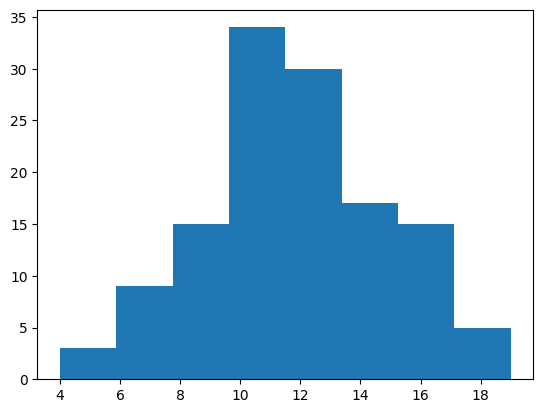

In [39]:
plt.hist(v_res, bins=8)

In [40]:
v_res.mean()

11.8671875

(array([ 3.,  5., 19., 14., 17., 28., 18., 19.,  2.,  3.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

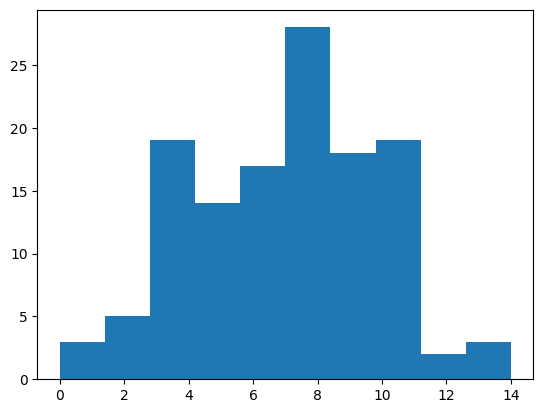

In [41]:
plt.hist(r_res)

In [42]:
r_res.mean()

6.96875

In [43]:
valueExamples = []
t = tqdm(range(128), desc='Generating gen 0 Value Player Examples')
for _ in t:
  valueExamples = valueExamples + playGame_YeildExamples(gwg, valueBasedPlayer(gwg, pvnetRandom))

Generating gen 0 Value Player Examples:   0%|          | 0/128 [00:00<?, ?it/s]

In [44]:
# Set up the game
gwg = gridWorldGames(128, 7, 7, 20, 30)
initBoard = gwg.getInitBoard()
pvnetValues = PolicyValueNetwork(gwg)

In [45]:
pvnetValues.train([valueExamples], targetType='total')

EPOCH ::: 1


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 26.07639285735786pi loss: 3.7743823751807213total loss: 29.850775238126516
EPOCH ::: 2


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 9.029616242274642pi loss: 3.6820278204977512total loss: 12.711644068360329
EPOCH ::: 3


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 7.761014590039849pi loss: 3.5364999026060104total loss: 11.297514531761408
EPOCH ::: 4


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 7.484250886365771pi loss: 3.203417781740427total loss: 10.68766867928207
EPOCH ::: 5


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 6.432743131183088pi loss: 2.7303229235112667total loss: 9.163066044449806
EPOCH ::: 6


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 6.247540983371437pi loss: 2.2514555784873664total loss: 8.498996544629335
EPOCH ::: 7


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 5.762214370071888pi loss: 1.988611781038344total loss: 7.750826148316264
EPOCH ::: 8


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 5.505101891234517pi loss: 1.7886240016669035total loss: 7.293725909665227
EPOCH ::: 9


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 5.258808464743197pi loss: 1.633050162345171total loss: 6.891858635470271
EPOCH ::: 10


Training Value Network:   0%|          | 0/256 [00:00<?, ?it/s]

v loss: 4.784982861019671pi loss: 1.5531495460309088total loss: 6.33813242893666


In [46]:
v_resV1 = playGame(gwg, valueBasedPlayer(gwg, pvnetValues), verbose=False)

In [47]:
#now see how that policy does

(array([ 2.,  4.,  8., 16., 56., 25., 12.,  5.]),
 array([ 0.  ,  2.25,  4.5 ,  6.75,  9.  , 11.25, 13.5 , 15.75, 18.  ]),
 <BarContainer object of 8 artists>)

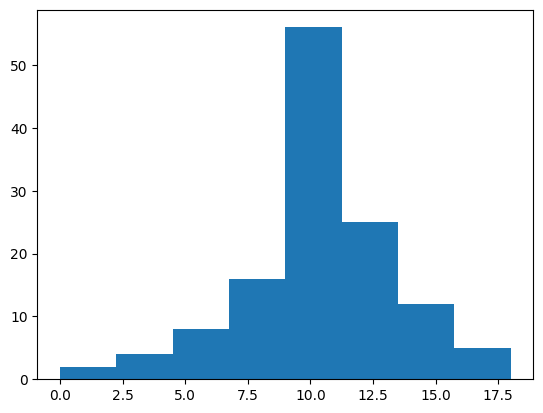

In [48]:
plt.hist(v_resV1, bins=8)

In [49]:
v_resV1.mean()

10.28125

In [51]:
valueExamples[21]

[array([[ 0.,  0., -1., -1.,  0.,  0., -1.],
        [-1.,  0., -1.,  0., -1.,  0., -1.],
        [ 0.,  0.,  0., -1., -1., -1., -1.],
        [-1.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 0., -1., -1.,  1.,  0.,  0., -1.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  0.,  0., -1., -1.]]),
 10.0,
 8.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 10.0]

In [52]:
idx=21
pvnetValues.predict(valueExamples[idx][0], valueExamples[idx][1], valueExamples[idx][2])

(array([[3.7472432e-07, 2.0823170e-06, 1.1285960e-06, 2.5817908e-06,
         1.8270391e-07, 9.1068557e-09, 4.5981454e-09, 2.4234179e-05,
         4.7134836e-06, 1.4248331e-05, 3.8233325e-06, 1.3618843e-06,
         2.4452029e-07, 2.1608750e-08, 9.3122179e-07, 1.9736504e-04,
         4.4277945e-04, 1.7616672e-05, 2.5073874e-05, 3.8946956e-07,
         1.3351386e-07, 1.2512117e-04, 6.2835359e-05, 5.8405014e-05,
         1.9470270e-01, 6.8909801e-05, 9.9561308e-05, 7.3544624e-07,
         3.8503440e-06, 2.0098669e-04, 1.7714649e-01, 7.7091820e-05,
         3.2879469e-01, 1.4692529e-04, 3.5244990e-05, 1.5912303e-05,
         2.8543040e-04, 7.3469615e-05, 2.8700650e-01, 8.6894004e-05,
         1.7335095e-03, 2.4696936e-05, 3.1262919e-06, 1.2895149e-05,
         5.4061469e-03, 4.2625459e-05, 2.9919669e-03, 7.6190950e-06,
         4.6329107e-05]], dtype=float32),
 array([12.032934], dtype=float32))

# Monte Carlo Player - the value player but with bigger roll outs

In [87]:
class MonteCarlo():
  """
  Implementation of Monte Carlo Algorithm
  """

  def __init__(self, game, nnet, args):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.nnet = nnet
    self.args = args

    self.Ps = {}  # Stores initial policy (returned by neural net)
    #self.Es = {}  # Stores game.getGameEnded ended for board s
    
  # Call this rollout
  def simulate(self, board, actions, actionIndexes):
    """
    Helper function to simulate one Monte Carlo rollout

    Args:
      board: triple (bathSize x xSize x ySize np.array of board position,
                     scalar of current score,
                     scalar of rounds left
      actions: batch size list/array of integer idexes for moves on each board
      these are assumed to be legal, no check for validity of moves
    Returns:
      temp_v:
        Terminal State
    """
    batchSize, xSize, ySize = board[0].shape
    nextBoard = self.game.getNextState_multiActions(board, actions, actionIndexes)
    #expand the game tree here, but just do straigt rollouts after this
    expandedBatchSize, _, _ = nextBoard[0].shape

    for i in range(self.args.maxDepth):  # maxDepth
      if nextBoard[2][0] <= 0:
        # check that game isn't over
        # assumes all boards have the same rounds left
        # no rounds left return scores as true values
        terminal_vs = nextBoard[1].copy()
        return terminal_vs
      else:
        pis, vs = self.nnet.predict(nextBoard[0], nextBoard[1], nextBoard[2])
        valids = self.game.getValidActions(nextBoard)
        maskedPis = pis * valids
        sumPis = np.sum(maskedPis, axis=1)
        sampledActions = np.zeros(expandedBatchSize, dtype=int)
      
        for g in range(expandedBatchSize):
          sg = self.game.stringRepresentation(nextBoard, g)
          if sumPis[g] > 0:
            probs = maskedPis[g] / sumPis[g]  # Renormalize    
          else:
            # If all valid moves being assigned zero probability by the policy net
            # NB! then either your NNet architecture is insufficient or you've get overfitting or something else.
            # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.
            log.error("All valid moves were masked, doing a workaround.")
            probs = valids[g] / np.sum(valids[g])
          self.Ps[sg] = probs
          sampledActions[g] = np.random.choice(xSize*ySize, p=probs)
        nextBoard = self.game.getNextState(nextBoard, sampledActions)
    
    pis, vs = self.nnet.predict(nextBoard[0], nextBoard[1], nextBoard[2])
    return vs

In [88]:
gwg = gridWorldGames(8, 7, 7, 20, 30)
initBoard = gwg.getInitBoard()

In [89]:
mc = MonteCarlo(gwg, pvnetValues, args)

In [90]:
(actionIndx, actions) = np.where(gwg.getValidActions(initBoard))
print(actions)
print(actionIndx)

[ 2  4 10 10 16 18 24 35 43 16 22 24 30  2  4 10 18 24 26 32 26 32 34 40
 14 22 28]
[0 0 0 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 5 6 6 6 6 7 7 7]


In [91]:
nextBoard = gwg.getNextState_multiActions(initBoard, actions, actionIndx)

In [92]:
nextBoard[0].shape

(27, 7, 7)

In [93]:
len(actions)

27

In [94]:
mc.simulate(initBoard, actions, actionIndx)

array([ 9.48622  , 13.471832 , 10.22736  , 12.040803 , 10.584301 ,
        9.909491 , 11.648791 , 10.772264 , 11.388273 , 14.501924 ,
       12.794814 , 15.485804 , 14.962328 ,  9.798315 ,  7.1277266,
        7.1277266, 12.186958 , 10.337002 , 11.242134 ,  6.960914 ,
        9.180091 ,  8.788225 , 11.388424 ,  9.9254   ,  6.595191 ,
       12.290087 , 10.808436 ], dtype=float32)

In [115]:
class MonteCarloBasedPlayer():
  """
  Simulate Player based on Monte Carlo Algorithm
  """

  def __init__(self, game, nnet, args):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.nnet = nnet
    self.args = args
    self.mc = MonteCarlo(self.game, self.nnet, self.args)
    self.K = self.args.mc_topk

  def play(self, board):
    """
    Simulate Play on a Board

    Args:
      board: triple (2d np.ndarray of board position,
                     scalar of current score,
                     scalar of rounds left

    Returns:
      best_action: tuple
        (avg_value, action) i.e., Average value associated with corresponding action
        i.e., Action with the highest topK probability
    """
    batchSize, xSize, ySize = board[0].shape
    self.qsa = [[] for ii in range(batchSize)]
    # there are only ever 3-4 actions explore them all, no only top 3
    pis, vs = self.nnet.predict(board[0], board[1], board[2])
    valids = self.game.getValidActions(board)
    maskedPis = pis * valids  # Masking invalid moves
    sumPis = np.sum(maskedPis, axis=1)
    numValidActions = np.sum(valids, axis=1)
    effectiveTopK = np.array(np.minimum(numValidActions, self.K), dtype= int)
    
    topKActionsIndex = []
    topKActions = []
    for g in range(batchSize):
      if sumPis[g] > 0:
        probs = maskedPis[g] / sumPis[g]  # Renormalize    
      else:
        # If all valid moves being assigned zero probability by the policy net
        # NB! then either your NNet architecture is insufficient or you've get overfitting or something else.
        # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.
        log.error("All valid moves were masked, doing a workaround.")
        probs = valids[g] / np.sum(valids[g])
      print(probs)
      print(effectiveTopK[g])
      topKActions = topKActions + list(np.argpartition(probs,-effectiveTopK[g])[-effectiveTopK[g]:])
      topKActionsIndex = topKActionsIndex + [g]*len(effectiveTopK[g])
    
    
    values = np.zeros(len(topKActions))
    # Do some rollouts
    for rollout in range(self.args.numMCsims):
      values = values + self.mc.simulate(board, topKActions, topKActionsIndex)
    values = values /  self.args.numMCsims
    print(topKActions)
    print(topKActionsIndex)
    print(values)

    bestActions = np.zeros(batchSize, dtype= int)
    bestAction1Hots = np.zeros((batchSize, self.game.getActionSize()))
    for g in range(batchSize):
      qsa_g = values[topKActionsIndex == g]
      bestActions[g] = topKActions[topKActionsIndex == g][np.argmax(qsa_g)][0]
      bestAction1Hots[g][bestActions[g]] = 1
    return bestActions, bestAction1Hots


In [116]:
mcp = MonteCarloBasedPlayer(gwg, pvnetValues, args)

In [117]:
mcp.play(initBoard)

[0.         0.         0.46875825 0.         0.34587246 0.
 0.         0.         0.         0.         0.18536928 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
3


IndexError: ignored

In [193]:
gwg.getValidActions(initBoard)

array([[1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

In [197]:
rp = randomPlayer(gwg)
rp.play(initBoard)[0]

array([ 2, 15, 37, 24])

In [199]:
mc.simulate(initBoard, np.array([ 6, 15, 37, 24]))

array([27.297895, 25.297668, 26.260235, 25.253021], dtype=float32)

#Graveyard

In [31]:
boards, currentScores, roundsLefts, pis, vs = list(zip(*randomExamples[20:84]))  # Length of boards, pis, vis = 64
boards = torch.FloatTensor(np.array(boards).astype(np.float64))
currentScores = torch.FloatTensor(np.array(currentScores).astype(np.float64))
roundsLefts = torch.FloatTensor(np.array(roundsLefts).astype(np.float64))
target_pis = torch.FloatTensor(np.array(pis).astype(np.float64))
target_vs = torch.FloatTensor(np.array(vs).reshape((-1, 1)).astype(np.float64))

# Predict
# To run on GPU if available
boards = boards.contiguous().to(args.device)
currentScores = currentScores.contiguous().to(args.device)
roundsLefts = roundsLefts.contiguous().to(args.device)
target_pis = target_pis.contiguous().to(args.device)
target_vs = target_vs.contiguous().to(args.device)

# Compute output
out_pi, out_v = pvnetRandom.nnet(boards, currentScores, roundsLefts)

In [ ]:
scores_ = []
pre_sample_efficiency_ = []
post_sample_efficiency_ = []
for ex_ in examples:
  scores_.append(ex_[-1])
  pre_sample_efficiency_.append(ex_[1]/(20 - ex_[2]))
  post_sample_efficiency_.append((ex_[-1] - ex_[1]) / ex_[2])
  if (ex_[-1] - ex_[1]) / ex_[2] > 1:
    print(ex_)

In [ ]:
plt.hist(scores_, bins = 8)

In [ ]:
plt.hist(np.array(pre_sample_efficiency_))

In [ ]:
plt.hist(post_sample_efficiency_)

In [ ]:
print(np.floor_divide(np.where(np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.33333333,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.33333333, 0.        , 0.33333333, 0.        ]) > 0)[0], 7))
print(np.remainder(np.where(np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.33333333,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.33333333, 0.        , 0.33333333, 0.        ]) > 0)[0], 7))

In [ ]:
l_ = Lists = [[] for i in range(4)]

In [ ]:
(actionIndx, actions) = np.where(gwg.getValidActions(initBoard))

In [ ]:
actions

In [ ]:
moves = (np.arange(len(actions)), 
         np.floor_divide(actions,gwg.ySize), 
         np.remainder(actions, gwg.ySize))
moves

In [ ]:
b = gridWorldBoards(len(actions), gwg.xSize, gwg.ySize, gwg.numFood, gwg.lifetime)
newPieces = np.array([initBoard[0][ai].copy() for ai in actionIndx])
newScores = np.array([initBoard[1][ai].copy() for ai in actionIndx])
newRoundsLeft = np.array([initBoard[2][ai].copy() for ai in actionIndx])

In [ ]:
newPieces.shape

In [ ]:
b.setState((newPieces, newScores, newRoundsLeft))
b.executeMoves(moves)
b.getState()

In [ ]:
l_[1].append('hi')

In [ ]:
l_

In [ ]:
os.getcwd()

In [ ]:
cd 

In [ ]:
ls

In [ ]:
#gwg.board.pieces

In [ ]:
x = [[]]*4

In [ ]:
x

In [ ]:
creatureLocs = list(zip(*np.where(gwg.board.pieces==1)))
print(creatureLocs[2])
gwg.display(2)

In [ ]:
gwg.displayMoves(2)

In [74]:
# print(game.stringRepresentation())
print('string representation of board state:')
print(gwg.stringRepresentationReadable())
# print(game.getScore())
# Observe the game board size
print(f'Board size = {gwg.getBoardSize()}')
#Observe the batch size
print(f'Batch size = {gwg.getBatchSize()}')
print(f'Board size = {gwg.getBoardSize()}')
# Observe the action size
print(f'Action size = {gwg.getActionSize()}')

# Observe the flat representation of allowed moves
#print(game.getValidActions())

string representation of board state:


TypeError: ignored

In [ ]:
for ii in range(4):
  gwg.display(ii)

In [ ]:
actions_ = randomPlay(gwg)

In [ ]:
_ = gwg.getNextState(actions_)

In [ ]:
for ii in range(4):
  gwg.display(ii)

In [ ]:
list_ = np.array()

In [ ]:
type(list_[0])

In [ ]:
from typing import NamedTuple

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray

def init(rng) -> Params:
  """Returns the initial model params."""
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)

def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = params.weight * x + params.bias
  return jnp.mean((pred - y) ** 2)

LEARNING_RATE = 0.005

@jax.jit
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Params:
  """Performs one SGD update step on params using the given data."""
  grad = jax.grad(loss)(params, x, y)

  # If we were using Adam or another stateful optimizer,
  # we would also do something like
  # ```
  # updates, new_optimizer_state = optimizer(grad, optimizer_state)
  # ```
  # and then use `updates` instead of `grad` to actually update the params.
  # (And we'd include `new_optimizer_state` in the output, naturally.)

  new_params = jax.tree_map(
    lambda param, g: param - g * LEARNING_RATE, params, grad)

  return new_params

In [ ]:
import matplotlib.pyplot as plt

rng = jax.random.PRNGKey(42)

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
x_rng, noise_rng = jax.random.split(rng)
xs = jax.random.normal(x_rng, (128, 1))
noise = jax.random.normal(noise_rng, (128, 1)) * 0.5
ys = xs * true_w + true_b + noise

# Fit regression
params = init(rng)
for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend();

In [ ]:
gw = GridWorldBoard(7,7,40,20)
print(gw.pieces.sum())
gw.pieces

In [ ]:
gw.execute_move((-1,0))
print(gw.pieces.sum())
gw.pieces

In [ ]:
gw.execute_move((-1,0))
print(gw.pieces.sum())
gw.pieces

In [ ]:
gw.pieces.sum()

In [ ]:
gw.numFood

In [ ]:
gw.execute_move((0,-1))
print(gw.pieces.sum())
gw.pieces

In [ ]:
gw.execute_move((-1,-1))
print(gw.pieces.sum())
gw.pieces

In [ ]:
move = (10,0)

oldCreatureLoc = list(zip(*np.where(gw.pieces==1)))[0]
foodLocs = list(zip(*np.where(gw.pieces==-1)))
intFoodLocs = np.ravel_multi_index((np.where(gw.pieces==-1)), (gw.xSize, gw.ySize))

newCreatureLoc = np.array(oldCreatureLoc) + move
    
#check bounce at boundaries
if newCreatureLoc[0] > gw.ySize:
  newCreatureLoc[0] = gw.ySize - 2
elif newCreatureLoc[0] < 0:
  newCreatureLoc[0] = 1
  
if newCreatureLoc[1] > gw.xSize:
  newCreatureLoc[1] = gw.xSize - 2
elif newCreatureLoc[1] < 0:
  newCreatureLoc[1] = 1

newIntFoodLoc = np.random.choice(list(set(np.arange(gw.xSize*gw.ySize)) - set(intFoodLocs)))
newxyFoodLoc = np.unravel_index(newIntFoodLoc, (gw.xSize, gw.ySize))

In [ ]:
newIntFoodLoc

In [ ]:
tuple(reversed(newxyFoodLoc))

In [ ]:
gw.pieces[newCreatureLoc]

In [ ]:
newCreatureLoc

In [ ]:
oldCreatureLoc

In [ ]:
pieces = [None]*7
for i in range(7):
  pieces[i] = [0]*7

In [ ]:
intLoc = np.random.choice(7 * 7, 11, replace=False)
xyLoc = np.unravel_index(intLoc, (7, 7))
pieces = np.zeros((7, 7))

In [ ]:
pieces[(xyLoc[1][0],xyLoc[0][0])] = 1
pieces[(xyLoc[1][1:],xyLoc[0][1:])] = -1

In [ ]:
pieces

In [ ]:
list(zip(*np.where(pieces==1)))[0] + np.array((1,0))

In [ ]:
np.where(pieces==1) + np.array((1,0))

In [ ]:
(1,1) in list(zip(*np.where(pieces==-1)))

In [ ]:
xyLoc

In [ ]:
pieces = pieces.at[tuple(xyLoc[0])].set(1)
for coord_ in xyLoc[1:]:
  print(coord_)
  pieces = pieces.at[tuple(coord_)].set(-1)

In [ ]:
pieces

In [ ]:
pieces = jnp.zeros((7, 7))

In [ ]:
class GridworldGame(Object):
  """
  Instantiate Othello Game
  """
  square_content = {
      -1: "X",
      +0: "-",
      +1: "O"
      }

  @staticmethod
  def getSquarePiece(piece):
    return OthelloGame.square_content[piece]

  def __init__(self, n):
    self.n = n

  def getInitBoard(self):
    # Return initial board (numpy board)
    b = Board(self.n)
    return np.array(b.pieces)

  def getBoardSize(self):
    # (a,b) tuple
    return (self.n, self.n)

  def getActionSize(self):
    # Return number of actions, n is the board size and +1 is for no-op action
    return self.n*self.n + 1

  def getCanonicalForm(self, board, player):
    # Return state if player==1, else return -state if player==-1
    return player*board

  def stringRepresentation(self, board):
    return board.tobytes()

  def stringRepresentationReadable(self, board):
    board_s = "".join(self.square_content[square] for row in board for square in row)
    return board_s

  def getScore(self, board, player):
    b = Board(self.n)
    b.pieces = np.copy(board)
    return b.countDiff(player)

  @staticmethod
  def display(board):
    n = board.shape[0]
    print("   ", end="")
    for y in range(n):
      print(y, end=" ")
    print("")
    print("-----------------------")
    for y in range(n):
      print(y, "|", end="")    # Print the row
      for x in range(n):
        piece = board[y][x]    # Get the piece to print
        print(OthelloGame.square_content[piece], end=" ")
      print("|")
    print("-----------------------")

  @staticmethod
  def displayValidMoves(moves):
      # Display possible moves
      A=np.reshape(moves[0:-1], board.shape)
      n = board.shape[0]
      print("  ")
      print("possible moves")
      print("   ", end="")
      for y in range(n):
        print(y, end=" ")
      print("")
      print("-----------------------")
      for y in range(n):
        print(y, "|", end="")    # Print the row
        for x in range(n):
          piece = A[y][x]    # Get the piece to print
          print(OthelloGame.square_content[piece], end=" ")
        print("|")
      print("-----------------------")

  def getNextState(self, board, player, action):
    """
    Helper function to make valid move
    If player takes action on board, return next (board,player)
    and action must be a valid move

    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]
      player: Integer
        ID of current player
      action: np.ndarray
        Space of actions

    Returns:
      (board,player) tuple signifying next state
    """
    if action == self.n*self.n:
      return (board, -player)
    b = Board(self.n)
    b.pieces = np.copy(board)
    move = (int(action/self.n), action%self.n)
    b.execute_move(move, player)
    return (b.pieces, -player)

  def getValidMoves(self, board, player):
    """
    Helper function to make valid move
    If player takes action on board, return next (board,player)
    and action must be a valid move

    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]
      player: Integer
        ID of current player
      action: np.ndarray
        Space of action

    Returns:
      valids: np.ndarray
        Returns a fixed size binary vector
    """
    valids = [0]*self.getActionSize()
    b = Board(self.n)
    b.pieces = np.copy(board)
    legalMoves =  b.get_legal_moves(player)
    if len(legalMoves)==0:
      valids[-1]=1
      return np.array(valids)
    for x, y in legalMoves:
      valids[self.n*x+y]=1
    return np.array(valids)

  def getGameEnded(self, board, player):
    """
    Helper function to signify if game has ended

    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]
      player: Integer
        ID of current player

    Returns:
      0 if not ended, 1 if player 1 won, -1 if player 1 lost
    """
    b = Board(self.n)
    b.pieces = np.copy(board)
    if b.has_legal_moves(player):
      return 0
    if b.has_legal_moves(-player):
      return 0
    if b.countDiff(player) > 0:
      return 1
    return -1

  def getSymmetries(self, board, pi):
    """
    Get mirror/rotational configurations of board

    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]
      pi: np.ndarray
        Dimension of board

    Returns:
      l: list
        90 degree of board, 90 degree of pi_board
    """
    assert(len(pi) == self.n**2+1)  # 1 for pass
    pi_board = np.reshape(pi[:-1], (self.n, self.n))
    l = []

    for i in range(1, 5):
      for j in [True, False]:
        newB = np.rot90(board, i)
        newPi = np.rot90(pi_board, i)
        if j:
          newB = np.fliplr(newB)
          newPi = np.fliplr(newPi)
        l += [(newB, list(newPi.ravel()) + [pi[-1]])]
    return l